In [1]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../")
import setigen as stg

# # 200
# i = 200
# fn = '/datax/users/bryanb/data/split_files/4194304_%04d.fil' % i
# fil = Waterfall(fn)

/Users/bbrzycki/anaconda3/envs/breakthroughlisten27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
stg.generate_signal

<module 'setigen.generate_signal' from '../setigen/generate_signal.py'>

In [3]:
tsamp = 18.253611008
fch1 = 6095.214842353016
df = -2.7939677238464355e-06

fchans = 1024
tchans = 16

In [4]:
fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

In [5]:
fs, ts

(array([6095.21484235, 6095.21483956, 6095.21483677, ..., 6095.21198971,
        6095.21198692, 6095.21198412]),
 array([  0.        ,  18.25361101,  36.50722202,  54.76083302,
         73.01444403,  91.26805504, 109.52166605, 127.77527706,
        146.02888806, 164.28249907, 182.53611008, 200.78972109,
        219.0433321 , 237.2969431 , 255.55055411, 273.80416512]))

In [6]:
data = np.zeros((ts.size, fs.size))

In [7]:
data[0].size

1024

In [8]:
def freq(time, f_start, drift_rate):
    """
    Calculates central frequency as a function of time, for linear frequency drift
    
    Args:
        time, NumPy array of timestamps
        f_start, starting frequency of signal
        drift_rate, slope of drift (make sure you use proper units)
    
    """
    return f_start + drift_rate * time

In [9]:
signal = freq(ts, fs[400], -0.000005)
signal

array([6095.21372477, 6095.2136335 , 6095.21354223, 6095.21345096,
       6095.21335969, 6095.21326843, 6095.21317716, 6095.21308589,
       6095.21299462, 6095.21290335, 6095.21281209, 6095.21272082,
       6095.21262955, 6095.21253828, 6095.21244701, 6095.21235575])

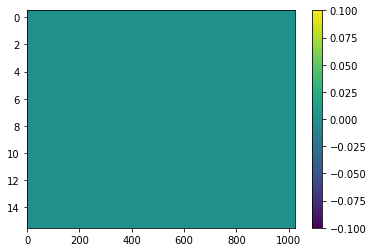

In [10]:
plt.imshow(data, aspect='auto')
plt.colorbar()

In [ ]:
for j in np.arange(ts.size):
    for i in np.arange(fs.size):
        

In [11]:
tt, ff = np.meshgrid(ts, fs)

In [13]:
tt, ff

(array([[  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        ...,
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512],
        [  0.        ,  18.25361101,  36.50722202, ..., 237.2969431 ,
         255.55055411, 273.80416512]]),
 array([[6095.21484235, 6095.21484235, 6095.21484235, ..., 6095.21484235,
         6095.21484235, 6095.21484235],
        [6095.21483956, 6095.21483956, 6095.21483956, ..., 6095.21483956,
         6095.21483956, 6095.21483956],
        [6095.21483677, 6095.21483677, 6095.21483677, ..., 6095.21483677,
         6095.21483677, 6095.214836

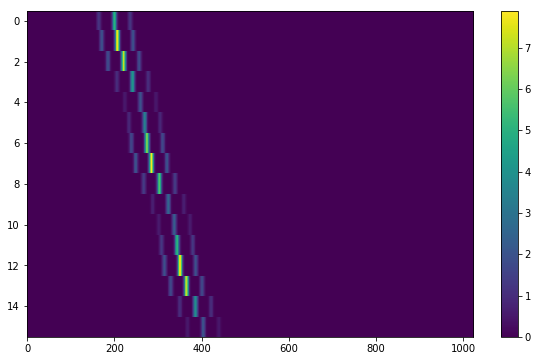

In [174]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

###

def constant_path(f_start, drift_rate):
    def path(t):
        return f_start + drift_rate * t
    return path

def squared_path(f_start, drift_rate):
    def path(t):
        return f_start + drift_rate * t**2
    return path

def sine_path(f_start, drift_rate, period, amplitude):
    def path(t):
        return f_start + amplitude * np.sin(2*np.pi*t/period) + drift_rate * t
    return path

###

def box_fprofile(width = 0.00001):
    def fprofile(f, f_center):
        return (np.abs(f-f_center) < width).astype(int)
    return fprofile

def gaussian_fprofile(width = 0.00001):
    def fprofile(f, f_center):
        return gaussian(f, f_center, width)
    return fprofile

def multiple_gaussian_fprofile(width = 0.00001):
    def fprofile(f, f_center):
        return gaussian(f, f_center - 0.0001, width)/4 \
            + gaussian(f, f_center, width) \
            + gaussian(f, f_center + 0.0001, width)/4
    return fprofile

###

def constant_intensity(level=1):
    def intensity(t):
        return level
    return intensity

def sine_intensity(period, amplitude=1, level=1):
    intensity = lambda t: amplitude * np.sin(2*np.pi*t/period) + level
    return intensity

###

def constant_bp_profile(level=1):
    def bp_profile(f):
        return level
    return bp_profile

def render(t, 
           f,
           path, 
           t_profile,
           f_profile,
           bp_profile):
    return t_profile(t) * f_profile(f, path(t)) * bp_profile(f)
    
test = render(tt, 
              ff, 
              sine_path(f_start = fs[200], drift_rate = -0.000002,
                         period = 100, amplitude = 0.00002),  
              sine_intensity(period = 100, amplitude = 3, level = 5),
              multiple_gaussian_fprofile(width = 0.00001),
              constant_bp_profile(level = 1))
plt.figure(figsize=(10,6))
plt.imshow(test, aspect='auto')
plt.colorbar()

In [175]:
tt

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 18.25361101,  18.25361101,  18.25361101, ...,  18.25361101,
         18.25361101,  18.25361101],
       [ 36.50722202,  36.50722202,  36.50722202, ...,  36.50722202,
         36.50722202,  36.50722202],
       ...,
       [237.2969431 , 237.2969431 , 237.2969431 , ..., 237.2969431 ,
        237.2969431 , 237.2969431 ],
       [255.55055411, 255.55055411, 255.55055411, ..., 255.55055411,
        255.55055411, 255.55055411],
       [273.80416512, 273.80416512, 273.80416512, ..., 273.80416512,
        273.80416512, 273.80416512]])

In [107]:
sine_intensity(ts, 1)

array([1.        , 1.99974262, 0.95463831, 0.00231559, 1.09063   ,
       1.99357222, 0.86428828, 0.01258548, 1.18051405, 1.97922399,
       0.77505526, 0.03098251, 1.26891233, 1.95681603, 0.6876737 ,
       0.05735527])

In [125]:
def f(a):
    return 2*a

def x(b):
    def f(a):
        return 2*a + b
    return f

In [129]:
x(3)(-1)

1

In [6]:
generate()

NameError: name 'generate' is not defined

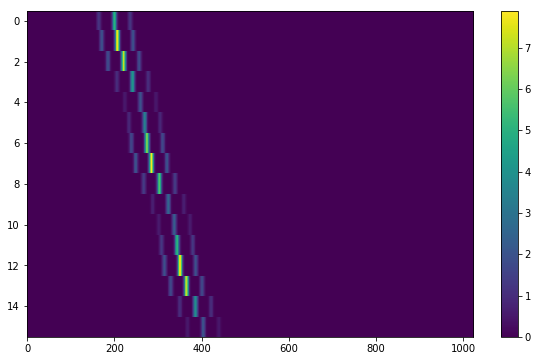

In [43]:
signal = stg.generate(ts, fs, stg.sine_path(f_start = fs[200], drift_rate = -0.000002,
                                            period = 100, amplitude = 0.00002),
                              stg.sine_t_profile(period = 100, amplitude = 3, level = 5),
                              stg.multiple_gaussian_f_profile(width = 0.00001),
                              stg.constant_bp_profile(level = 1))

fig = plt.figure(figsize=(10,6))
im = plt.imshow(signal, aspect='auto')
plt.colorbar()
# fig.savefig("image.png")

In [4]:
signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[200], drift_rate = -0.000002),
                          stg.constant_t_profile(level = 1),
                          stg.box_f_profile(width = 0.00001),
                          stg.constant_bp_profile(level = 1))

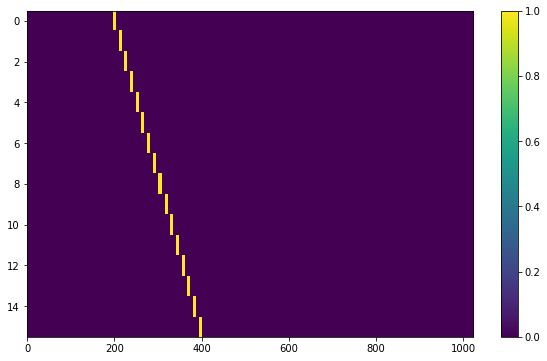

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()
fig.savefig("../doc/source/cookbook/basic_signal.png", bbox_inches='tight')

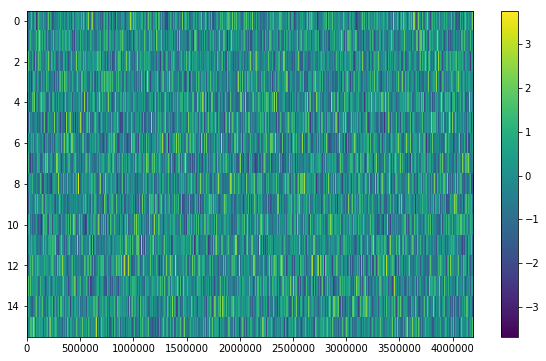

In [8]:
ts = stg.get_ts(fn)
fs = stg.get_fs(fn)
data = stg.get_data(fn)

fig = plt.figure(figsize=(10,6))
plt.imshow(stg.normalize(data), aspect='auto')
plt.colorbar()

In [9]:
fil.header

{'az_start': 0.0,
 'data_type': 1,
 'fch1': 6095.214842353016,
 'foff': -2.7939677238464355e-06,
 'machine_id': 20,
 'nbits': 32,
 'nchans': 4194304,
 'nifs': 1,
 'source_name': 'HIP43223',
 'src_dej': <Angle 18.7477 deg>,
 'src_raj': <Angle 8.80492 hourangle>,
 'telescope_id': 6,
 'tsamp': 18.253611008,
 'tstart': 58090.468206018515,
 'za_start': 0.0}

In [10]:
4194304/4

1048576

In [11]:
1744830464 / 1048576

1664

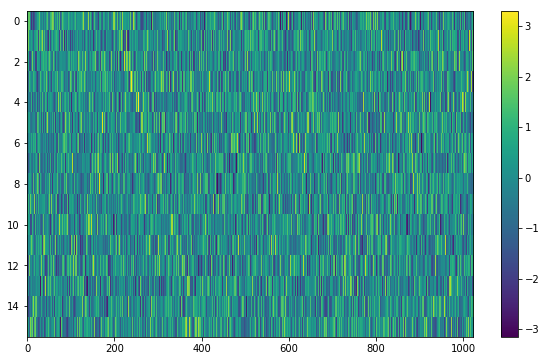

In [4]:
signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[200], drift_rate = -0.000002),
                          stg.constant_t_profile(level = 2.0),
                          stg.box_f_profile(width = 0.00001),
                          stg.constant_bp_profile(level = 1.0))

fig = plt.figure(figsize=(10,6))
plt.imshow(stg.normalize(stg.inject_noise(signal)), aspect='auto')
plt.colorbar()

In [16]:
stg.gaussian

<function f_profiles.gaussian(x, mu, sig)>

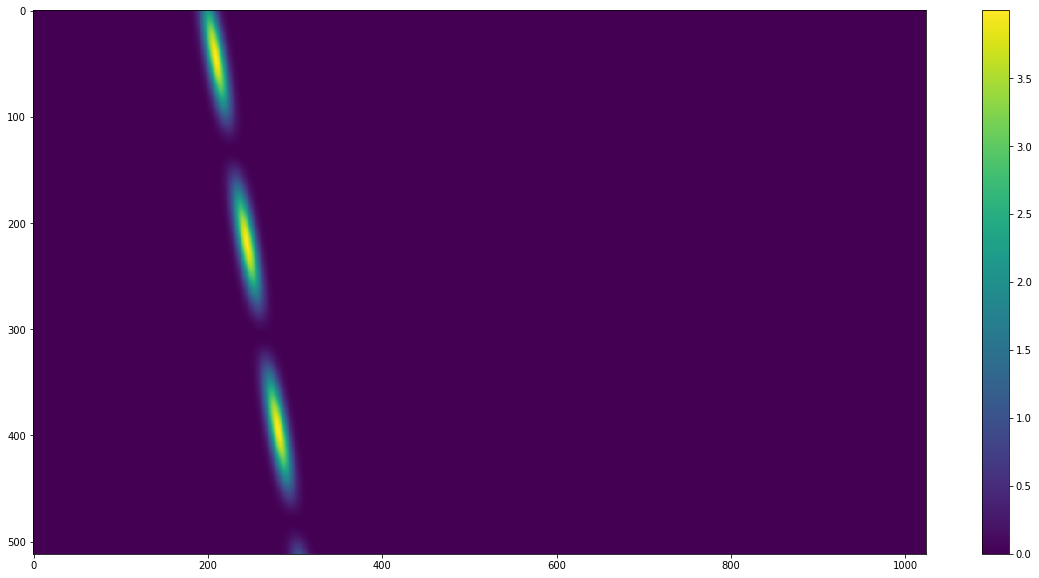

In [120]:
def periodic_gaussian_t_profile(period, phase, sigma, pulse_dir, width, pnum = 1, amplitude = 1, level = 0):
    # pulse_dir can be 'up', 'down', 'rand'
    # width is width of individual pulses, sigma is variation in period
    def t_profile(t):
        center_ks = np.round((t + phase) / period - 1 / 4.)
        if pnum % 2 == 1:
            temp = (pnum - 1) / 2
            center_ks = np.array([center_ks + 1 * i for i in np.arange(-temp, temp + 1)])
        else:
            temp = pnum / 2
            center_ks = np.array([center_ks + 1 * i for i in np.arange(-temp + 1, temp + 1)])
        centers = (4. * center_ks + 1.) / 4. * period - phase
        
        # Calculate unique offsets per pulse and add to centers of Gaussians
        unique_centers = np.unique(center_ks)
        
        offset_dict = dict(zip(unique_centers, np.random.normal(0, sigma, unique_centers.shape)))
        get_offsets = np.vectorize(lambda x: offset_dict[x])
        
        sign_list = []
        for c in unique_centers:
            x = np.random.uniform(0, 1)
            if pulse_dir == 'up' or pulse_dir == 'rand' and x < 0.5:
                sign_list.append(1)
            elif pulse_dir == 'down' or pulse_dir == 'rand':
                sign_list.append(-1)
            else:
                sys.exit('Invalid pulse direction!')
        sign_dict = dict(zip(unique_centers, sign_list))
        get_signs = np.vectorize(lambda x: sign_dict[x])
        
        centers += get_offsets(center_ks)
        center_signs = zip(centers, get_signs(center_ks))
    
        intensity = 0
        for c, sign in center_signs:
            intensity += sign * amplitude * stg.gaussian(t, c, width)
            
        intensity += level
        relu = np.vectorize(lambda x: max(0,x))
        return relu(intensity)
    return t_profile

scale_factor = 32
tsamp = 18.253611008/scale_factor
# tsamp = 0.5
fch1 = 6095.214842353016
df = -2.7939677238464355e-06
# df = -2e-06

fchans = 1024
tchans = 16*scale_factor
# tchans = 512

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

# signal = stg.generate(ts,
#                           fs,
#                           stg.constant_path(f_start = fs[200], drift_rate = -0.000002),
#                           periodic_gaussian_t_profile(period = 3, phase = 0, sigma = 1, pulse_dir = 'rand', width = 1, pnum = 10, amplitude = 1, level = 2),
#                           stg.gaussian_f_profile(width = 0.000025),
#                           stg.constant_bp_profile(level = 1.0),
#                           integrate = True,
#                           samples = 20)

signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[200], drift_rate = -0.000001),
                          stg.sine_t_profile(period = 100, phase = 0, amplitude = 2, level = 2),
                          stg.gaussian_f_profile(width = 0.00002),
                          stg.constant_bp_profile(level = 1.0),
                          integrate = True)

fig = plt.figure(figsize=(20,10))
plt.imshow((signal), aspect='auto')
plt.colorbar()

(512,)
512


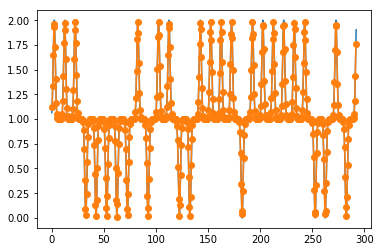

In [46]:
scale_factor = 32
tsamp = 18.253611008/scale_factor
# tsamp = 0.5
fch1 = 6095.214842353016
df = -2.7939677238464355e-06
# df = -2e-06

fchans = 1024
tchans = 16*scale_factor
# tchans = 512

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)
print(ts.shape)
samples = 32

func = periodic_gaussian_t_profile(period = 10, phase = 0, sigma = 0.1, pulse_dir = 'rand', width = 1, pnum = 3, amplitude = 1, level = 1)
new_ts = np.arange(0, tchans*tsamp, tsamp/samples)
y = func(new_ts)

# y = func(ts)
# plt.plot(ts, y)

# import scipy.integrate as integrate
# import scipy.special as special
new_y = []
for i in range(len(ts)):
    tot = 0
    for j in range(samples*i, samples*(i+1)):
        tot += y[j]
    new_y.append(tot / samples)
#     val = integrate.quad(func, ts[i], ts[i] + tsamp, limit=10)[0] / tsamp
#     new_ts.append(val)
print(len(new_y))
plt.plot(new_ts, y)
plt.plot(ts+tsamp/2, new_y, 'o-')

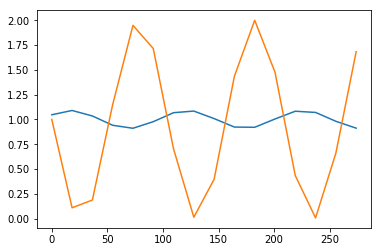

In [516]:
import scipy.integrate as integrate
import scipy.special as special
new_ts = []
for i in range(len(ts)):
    val = integrate.quad(stg.sine_t_profile(period = 10, amplitude=1, level=1), ts[i], ts[i] + tsamp)[0] / tsamp
    new_ts.append(val)
plt.plot(ts, new_ts)
plt.plot(ts, stg.sine_t_profile(period = 10, amplitude=1, level=1)(ts))

In [519]:
ff, tt = np.meshgrid(fs, ts)
tt

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 18.25361101,  18.25361101,  18.25361101, ...,  18.25361101,
         18.25361101,  18.25361101],
       [ 36.50722202,  36.50722202,  36.50722202, ...,  36.50722202,
         36.50722202,  36.50722202],
       ...,
       [237.2969431 , 237.2969431 , 237.2969431 , ..., 237.2969431 ,
        237.2969431 , 237.2969431 ],
       [255.55055411, 255.55055411, 255.55055411, ..., 255.55055411,
        255.55055411, 255.55055411],
       [273.80416512, 273.80416512, 273.80416512, ..., 273.80416512,
        273.80416512, 273.80416512]])

In [524]:
np.meshgrid(fs, new_ts)[1]

array([[1.04743092, 1.04743092, 1.04743092, ..., 1.04743092, 1.04743092,
        1.04743092],
       [1.09068895, 1.09068895, 1.09068895, ..., 1.09068895, 1.09068895,
        1.09068895],
       [1.03527938, 1.03527938, 1.03527938, ..., 1.03527938, 1.03527938,
        1.03527938],
       ...,
       [1.07093194, 1.07093194, 1.07093194, ..., 1.07093194, 1.07093194,
        1.07093194],
       [0.98168945, 0.98168945, 0.98168945, ..., 0.98168945, 0.98168945,
        0.98168945],
       [0.91236844, 0.91236844, 0.91236844, ..., 0.91236844, 0.91236844,
        0.91236844]])

In [45]:
np.random.normal(0,1)

0.40142564878958625

In [64]:

np.random.uniform(0, 1)

0.5060568053245192